<a href="https://colab.research.google.com/github/andrewwatson1022/Pokemon/blob/main/Clustering_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

As a kid, I organized my treasured binder of Pokemon cards by type: fire, electric, water, etc. While grouping by this categorical feature made intuitive sense (fire Pokemon cards are red), I wanted to survey alternate methods of categorizing Pokemon.

In this unsupervised learning study, I explored numeric video game data on Pokemon species and reduced dimensionality through principal component analysis. Additionally, I applied k-means clustering to bracket Pokemon based on all the numeric data available and, alternatively, just on their battle metrics. I found that two principal components explain 56.2% of the variance in all the numeric metrics and 62.6% of the variance in just the battle metrics. However, the extra data with all the numeric metrics allowed my k-means model to distinguish three clusters of Pokemon species, while the model fit to the just the battle data was only able to identify two clusters.

#Import and Clean

These are the libraries I used for this analysis.

In [1]:
import pandas as pd #data frames
import seaborn as sns #heatmap
from matplotlib import pyplot as plt #visualizations
from sklearn.preprocessing import StandardScaler #scale data
from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans #clustering
from tabulate import tabulate #tables

The Pokemon dataset was originally curated by Mario Tormo Romero and uploaded to [Kaggle](https://www.kaggle.com/datasets/mariotormo/complete-pokemon-dataset-updated-090420). It contains records for 1,045 species of Pokemon.

In [2]:
pokemon = pd.read_csv('https://raw.githubusercontent.com/andrewwatson1022/Pokemon/main/pokedex_(Update_04.21).csv')
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1045 non-null   int64  
 1   pokedex_number    1045 non-null   int64  
 2   name              1045 non-null   object 
 3   german_name       1045 non-null   object 
 4   japanese_name     1045 non-null   object 
 5   generation        1045 non-null   int64  
 6   status            1045 non-null   object 
 7   species           1045 non-null   object 
 8   type_number       1045 non-null   int64  
 9   type_1            1045 non-null   object 
 10  type_2            553 non-null    object 
 11  height_m          1045 non-null   float64
 12  weight_kg         1044 non-null   float64
 13  abilities_number  1045 non-null   int64  
 14  ability_1         1042 non-null   object 
 15  ability_2         516 non-null    object 
 16  ability_hidden    813 non-null    object 


Some of the data relates to Pokemon battles like "Attack" or "Speed", but quite a bit of this data goes beyond battling.

In [3]:
pokemon.head()

,Unnamed: 0,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,0,1,Bulbasaur,Bisasam,フシギダネ (Fushigidane),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,1,2,Ivysaur,Bisaknosp,フシギソウ (Fushigisou),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,2,3,Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,3,3,Mega Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
4,4,4,Charmander,Glumanda,ヒトカゲ (Hitokage),1,Normal,Lizard Pokémon,1,Fire,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5


There are no duplicate entries in the data set.

In [4]:
pokemon[pokemon.duplicated(keep=False)]

,Unnamed: 0,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy


Large numbers of Pokemon are missing data. Some of this may be an issue, but at times, NA values might be appropriate. For example, many Pokemon do not have a "type_2". I narrowed my data frame to only numeric data before I cut null records.

In [5]:
pokemon.isna().sum()

Unnamed: 0            0
pokedex_number        0
name                  0
german_name           0
japanese_name         0
generation            0
status                0
species               0
type_number           0
type_1                0
type_2              492
height_m              0
weight_kg             1
abilities_number      0
ability_1             3
ability_2           529
ability_hidden      232
total_points          0
hp                    0
attack                0
defense               0
sp_attack             0
sp_defense            0
speed                 0
catch_rate           18
base_friendship     115
base_experience     120
growth_rate           1
egg_type_number       0
egg_type_1            3
egg_type_2          760
percentage_male     173
egg_cycles            1
against_normal        0
against_fire          0
against_water         0
against_electric      0
against_grass         0
against_ice           0
against_fight         0
against_poison        0
against_ground  

Because my goal was to cluster numeric data, I trimmed my data frame to relevant integers and floats. I left out some variables like "type_number" and "ability_number" because they are essentially categorical stand-ins. I also removed "percentage_male" because 173 Pokemon species don't have a sex. Lastly, "total_points" is just an engineered variable that sums the battle metrics. I cut this variable to avoid double-counting.

In [6]:
#removed total points because engineered variable
numeric = pokemon[['name','height_m', 'weight_kg', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship',
       'base_experience', 'egg_cycles']]
numeric

,name,height_m,weight_kg,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,egg_cycles
0,Bulbasaur,0.7,6.9,45,49,49,65,65,45,45.0,70.0,64.0,20.0
1,Ivysaur,1.0,13.0,60,62,63,80,80,60,45.0,70.0,142.0,20.0
2,Venusaur,2.0,100.0,80,82,83,100,100,80,45.0,70.0,236.0,20.0
3,Mega Venusaur,2.4,155.5,80,100,123,122,120,80,45.0,70.0,281.0,20.0
4,Charmander,0.6,8.5,39,52,43,60,50,65,45.0,70.0,62.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,Glastrier,2.2,800.0,100,145,130,65,110,30,3.0,NaN,NaN,120.0
1041,Spectrier,2.0,44.5,100,65,60,145,80,130,3.0,NaN,NaN,120.0
1042,Calyrex,1.1,7.7,100,80,80,80,80,80,3.0,NaN,NaN,120.0
1043,Calyrex Ice Rider,2.4,809.1,100,165,150,85,130,50,3.0,NaN,NaN,120.0


After narrowing the data frame to numeric columns, 120 Pokemon species still have missing data. I'm familiar enough with the franchise to know that all of these Pokemon were introduced after the Sun and Moon games. By cutting this sample from that dataset, I would be losing a generation of species, but I have no reason to believe that these Pokemon species would be distinct from the rest of the data set.

In [7]:
numeric[numeric.isna().any(axis=1)]

,name,height_m,weight_kg,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,egg_cycles
69,Galarian Meowth,0.4,7.5,50,65,55,40,40,40,NaN,NaN,NaN,20.0
100,Galarian Ponyta,0.8,24.0,50,85,55,65,65,90,NaN,NaN,NaN,20.0
102,Galarian Rapidash,1.7,80.0,65,100,70,80,80,105,NaN,NaN,NaN,20.0
107,Galarian Slowbro,1.6,70.5,95,100,95,100,70,30,75.0,70.0,NaN,20.0
111,Galarian Farfetch'd,0.8,42.0,52,95,55,58,62,55,NaN,NaN,NaN,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,Glastrier,2.2,800.0,100,145,130,65,110,30,3.0,NaN,NaN,120.0
1041,Spectrier,2.0,44.5,100,65,60,145,80,130,3.0,NaN,NaN,120.0
1042,Calyrex,1.1,7.7,100,80,80,80,80,80,3.0,NaN,NaN,120.0
1043,Calyrex Ice Rider,2.4,809.1,100,165,150,85,130,50,3.0,NaN,NaN,120.0


While browsing for data issues, I came across entries for Mega Pokemon. Mega Pokemon are not really distinct species from their non-mega counterparts. Their stats are just temporarily boosted for a battle. Think Cocaine Bear.

In [8]:
numeric[numeric.name.str.startswith('Mega ')].head()

,name,height_m,weight_kg,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,egg_cycles
3,Mega Venusaur,2.4,155.5,80,100,123,122,120,80,45.0,70.0,281.0,20.0
7,Mega Charizard X,1.7,110.5,78,130,111,130,85,100,45.0,70.0,285.0,20.0
8,Mega Charizard Y,1.7,100.5,78,104,78,159,115,100,45.0,70.0,285.0,20.0
12,Mega Blastoise,1.6,101.1,79,103,120,135,115,78,45.0,70.0,284.0,20.0
19,Mega Beedrill,1.4,40.5,65,150,40,15,80,145,45.0,70.0,223.0,15.0


Along the same lines, Primal Kyogre and Groundon are not separate species. They are just boosted forms.

In [9]:
numeric[numeric.name.str.startswith('Primal ')].head()

,name,height_m,weight_kg,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,egg_cycles
460,Primal Kyogre,9.8,430.0,100,150,90,180,160,90,5.0,0.0,347.0,120.0
462,Primal Groudon,5.0,999.7,100,180,160,150,90,90,5.0,0.0,347.0,120.0


I removed the Mega Pokemon, Primal Pokemon, and Pokemon with null values from the data frame. There are still 875 distinct species to be analyzed.

In [10]:
clean = numeric[~numeric.name.str.startswith('Mega ')].dropna()
clean = clean[~clean.name.str.startswith('Primal ')].reset_index(drop=True)
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             875 non-null    object 
 1   height_m         875 non-null    float64
 2   weight_kg        875 non-null    float64
 3   hp               875 non-null    int64  
 4   attack           875 non-null    int64  
 5   defense          875 non-null    int64  
 6   sp_attack        875 non-null    int64  
 7   sp_defense       875 non-null    int64  
 8   speed            875 non-null    int64  
 9   catch_rate       875 non-null    float64
 10  base_friendship  875 non-null    float64
 11  base_experience  875 non-null    float64
 12  egg_cycles       875 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 89.0+ KB


#Exploratory Data Analysis

The heatmap below illustrates the correlation between the retained numeric variables. Almost all of the metrics correlate positively. This makes intuitive sense; bigger Pokemon species tend to be stronger. Exceptions are "catch_rate" and "base_friendship", which correlate negatively with the rest of the variables. This would suggest that bigger/stronger Pokemon are harder to catch and are less friendly when initially captured.

<AxesSubplot:>

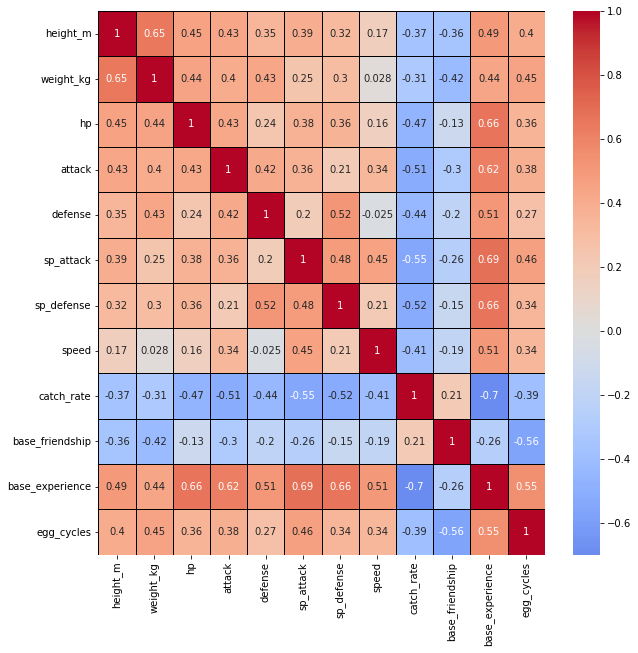

In [11]:
plt.figure(figsize=(10,10))

#correlation heatmap
sns.heatmap(clean.corr(),
            annot = True,
            fmt = '.2g',
            center = 0,
            cmap = 'coolwarm',
            linewidths = 1,
            linecolor = 'black')

###Battle Metrics

The crux of the Pokeon games, besides catching them all, is training your Pokemon through battles. The following variables constitute the Pokemon battle mechanics.

The "hp" (hit points) variable measures the Pokemon's health. It is fairly normally distributed with a few positive outliers.

<AxesSubplot:>

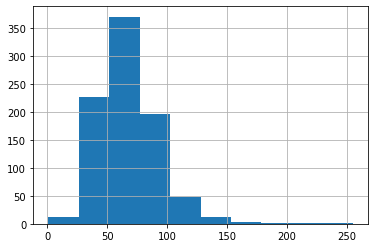

In [12]:
clean['hp'].hist()

The "attack" variable determines the strength of physical attacks. It is mostly normally distributed.

<AxesSubplot:>

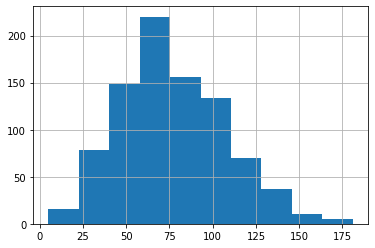

In [13]:
clean['attack'].hist()

The "defense" variable determines the resistance to physical attacks. It is fairly normally distributed with some positive outliers.

<AxesSubplot:>

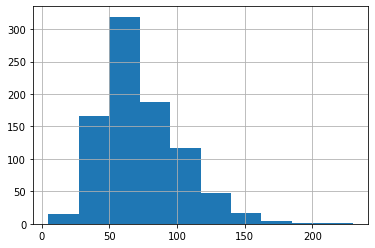

In [14]:
clean['defense'].hist()

The "sp_attack" variable determines the strength of special attacks. The distribution skews right.

<AxesSubplot:>

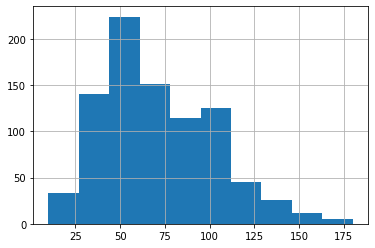

In [15]:
clean['sp_attack'].hist()

The "sp_defense" variable determines the resistance to special attacks. The distribution also skews to the right.

<AxesSubplot:>

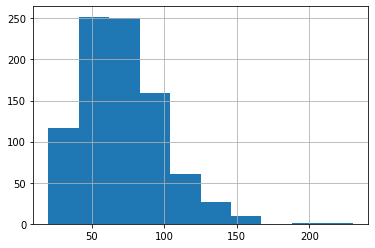

In [16]:
clean['sp_defense'].hist()

The “speed” variable determines which Pokemon attacks first. It is distributed fairly normally.

<AxesSubplot:>

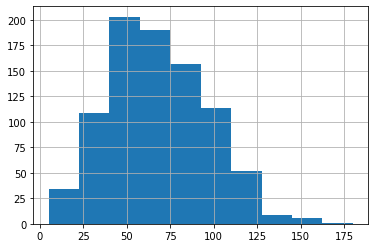

In [17]:
clean['speed'].hist()

###Non-Battle Metrics

The non-battle metrics are not related to Pokemon battling, but may be helpful in establishing clusters.

The "height_m" distribution skews right. Most Pokemon species come under 2 meters, but there are some monster-sized outliers.

<AxesSubplot:>

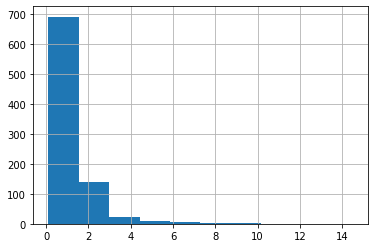

In [18]:
clean['height_m'].hist()

Like "height_m", the "weight_kg" distribution skews right. Most Pokemon species weigh less than 100kg, but there are some monster-sized outliers.

<AxesSubplot:>

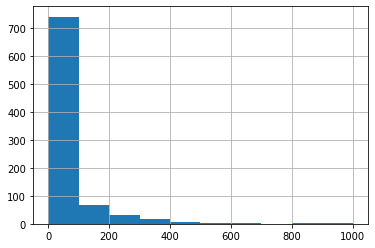

In [19]:
clean['weight_kg'].hist()

The "catch_rate" determines how easy it is to capture a Pokemon. Pokemon with a high catch rate are less likely to break out of the PokeBall. This is not a normal distribution.

<AxesSubplot:>

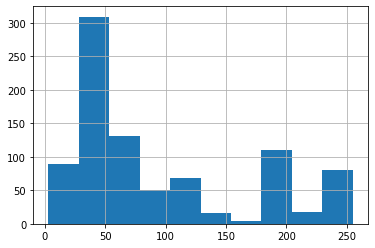

In [20]:
clean['catch_rate'].hist()

The "base_friendship" metric explains the affinity a Pokemon feels towards its trainer immediately after being captured. This couldn't be any further from a normal distribution. Almost all Pokemon start with a base friendship around 80.

<AxesSubplot:>

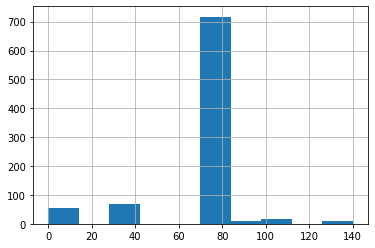

In [21]:
clean['base_friendship'].hist()

The "base_experience" variable determines the amount of experience points or growth the opposing Pokemon receives as a reward for winning the battle. Stronger Pokemon award more experience when they are defeated. This metric is somewhat bimodal.

<AxesSubplot:>

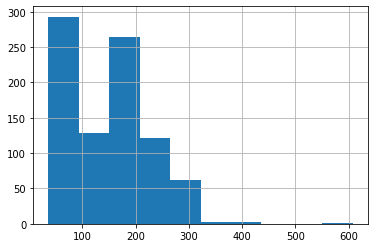

In [22]:
clean['base_experience'].hist()

Lastly, "egg_cycle" variable explains how long it takes for a Pokemon egg to hatch with higher numbers requiring more time. Most Pokemon species have a value around 20, but there are some extreme outliers.

<AxesSubplot:>

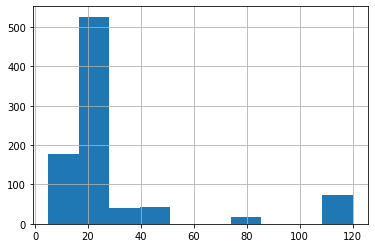

In [23]:
clean['egg_cycles'].hist()

#Subset Battle Metrics & Standardize

I subset the battle metrics. I also standardized an array for PCA and k-means clustering.

In [24]:
#subset data
battle = clean[['hp', 'attack', 'defense','sp_attack', 'sp_defense', 'speed']]

#scale
scaler = StandardScaler()
scaler.fit(battle)
battle_array = scaler.transform(battle)

battle_array

array([[-0.90995042, -0.93889282, -0.79334484, -0.18500475, -0.20535716,
        -0.77640784],
       [-0.34036347, -0.50711979, -0.32219177,  0.30297503,  0.34493126,
        -0.24879301],
       [ 0.41908581,  0.1571464 ,  0.35088403,  0.95361474,  1.07864916,
         0.45469344],
       ...,
       [-0.302391  ,  1.78459859,  4.65856918, -0.57538858,  1.11533505,
        -1.90198616],
       [-0.60617071,  1.65174535, -0.65872967,  2.61274599,  0.30824537,
         1.40440015],
       [ 0.72286552,  1.1535457 ,  0.08165371,  1.01867871,  0.34493126,
         2.67067576]])

Likewise, I standardized an array with all the numeric data.

In [25]:
#reset index
all = clean[['height_m', 'weight_kg', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship',
       'base_experience', 'egg_cycles']]

#scale
scaler = StandardScaler()
scaler.fit(all)
all_array = scaler.transform(all)

all_array

array([[-0.41529242, -0.49212599, -0.90995042, ...,  0.26039257,
        -1.10191322, -0.35058392],
       [-0.1640496 , -0.43906549, -0.34036347, ...,  0.26039257,
        -0.07501965, -0.35058392],
       [ 0.67342647,  0.31769888,  0.41908581, ...,  0.26039257,
         1.16251875, -0.35058392],
       ...,
       [ 3.60459269,  6.58057646, -0.302391  , ..., -3.06926186,
         1.4389901 ,  3.12743119],
       [ 0.50593125, -0.43906549, -0.60617071, ..., -3.06926186,
         1.4389901 ,  3.12743119],
       [ 0.25468843, -0.1650646 ,  0.72286552, ..., -3.06926186,
         1.61013903,  3.12743119]])

#Principal Component Analysis

###All Metrics

For all the numeric data, I used the elbow method with a scree plot to determine the ideal number of principal components. After two components, the eigenvalues level off.

Text(0.5, 1.0, 'Scree Plot')

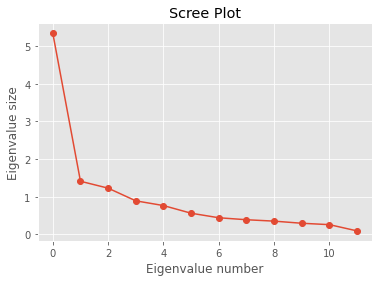

In [26]:
# Make an instance of the Model
pca = PCA(n_components=12)
pca.fit(all_array)

plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

Reducing all the numeric data down to two principal components explains 56.2% of the overall variance. The first principal component accounts for 44.5% of the variance and the second principal component accounts for 11.7%.

In [27]:
pca = PCA(n_components=2)
pca.fit(all_array)
pca.explained_variance_ratio_*100

array([44.49212722, 11.73905917])

The heatmap below illustrates the loadings for both principal components. The first principal component mostly reflects the correlation heatmap earlier with absolute loading values between 0.2 and 0.4. As Pokemon get bigger, they also tend to become stronger but also more difficult to catch and are less initially friendly with their trainers.

The second principal component correlates differently. It correlates most strongly with "speed" at -0.52 and "weight_kg" at 0.5. My hunch is that it distinguishes generally powerful Pokemon from just heavier/slower Pokemon.

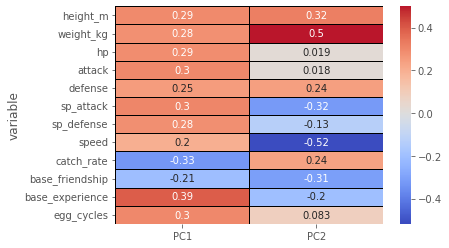

In [28]:
loadings = pca.components_
num_pc = pca.n_features_in_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = all.columns.values
loadings_df = loadings_df.set_index('variable')
ax = sns.heatmap(loadings_df, center = 0, annot=True, cmap='coolwarm', linewidths = 1, linecolor = 'black')
plt.show()

I fit a data set with the principal component values for each Pokemon. This data set was later applied in the k-means section to visualize the clusters.

In [29]:
# Fit and transform data
pca_features = pca.fit_transform(all_array)
 
# Create dataframe
all_pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
all_pca_df['name'] = clean.name
all_pca_df.head()

,PC1,PC2,name
0,-1.636208,-0.166264,Bulbasaur
1,-0.326452,-0.632728,Ivysaur
2,1.743582,-0.711562,Venusaur
3,-1.817494,-0.473296,Charmander
4,-0.346406,-0.913860,Charmeleon


###Battle Metrics

Returning to the battle-specific data, I used the elbow method with a scree plot to determine the ideal number of principal components. After two components, the eigenvalues level off, though not as sharply as before with all of the numeric metrics.

Text(0.5, 1.0, 'Scree Plot')

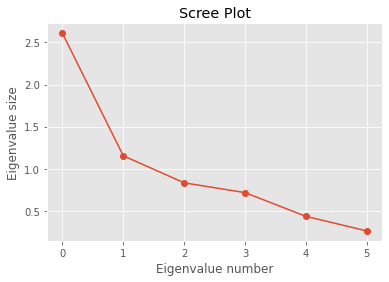

In [30]:
# Make an instance of the Model
pca = PCA(n_components=6)
pca.fit(battle_array)

plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

Reducing the battle metrics down to two principal components explains 62.6% of the variance. The first component handles 43.4% and the second component explains an additional 19.2%.

In [31]:
pca = PCA(n_components=2)
pca.fit(battle_array)
pca.explained_variance_ratio_*100

array([43.43778308, 19.20573985])

The principal component loadings for the battle metrics reflect a similar pattern to the loadings of all the numeric metrics. The first principal component correlates positively with all the battle variables, contributing to my theory that powerful pokemon are strong all-around.

Similar to all the metrics, the second principal component for the battle metrics correlates most strongly with "speed" at -0.67 and "defense" at 0.61. These inverse correlations again suggest the second component is distinguishing slow defensive Pokemon.

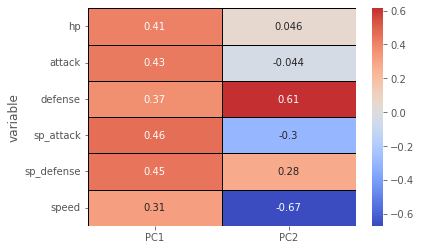

In [32]:
loadings = pca.components_
num_pc = pca.n_features_in_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = battle.columns.values
loadings_df = loadings_df.set_index('variable')

ax = sns.heatmap(loadings_df, center = 0, annot=True, cmap='coolwarm', linewidths = 1, linecolor = 'black')
plt.show()

Finally, I fit a data set with the battle-specific principal component values for each Pokemon. This data set was later applied in the k-means section to visualize the clusters.

In [33]:
# Fit and transform data
pca_features = pca.fit_transform(all_array)
 
# Create dataframe
battle_pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
battle_pca_df['name'] = clean.name
battle_pca_df

,PC1,PC2,name
0,-1.636208,-0.166264,Bulbasaur
1,-0.326452,-0.632728,Ivysaur
2,1.743582,-0.711562,Venusaur
3,-1.817494,-0.473296,Charmander
4,-0.346406,-0.913860,Charmeleon
...,...,...,...
870,1.619308,0.349739,Poipole
871,4.040993,0.245792,Naganadel
872,6.671013,7.350203,Stakataka
873,3.753128,-1.088787,Blacephalon


#K-Means Clustering

###All Metrics

I used the elbow method with inertia to determine the ideal number of clusters for all the numeric variables. After three clusters, the decrease in inertia with each cluster diminishes.

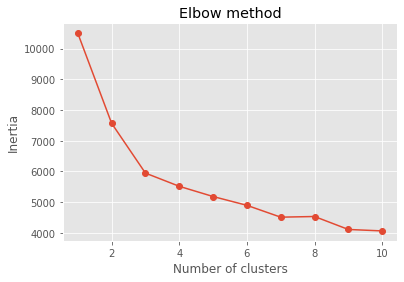

In [34]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=4)
    kmeans.fit(all_array)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

I fit all the numerical data to a three cluster model and added the individual Pokemon cluster designations to the battle_pca_df.

In [35]:
kmeans_all = KMeans(n_clusters=3, n_init='auto', random_state=4)
kmeans_all.fit(all_array)

all_pca_df['cluster_number'] = pd.Series(kmeans_all.predict(all_array))
all_pca_df

,PC1,PC2,name,cluster_number
0,-1.636208,-0.166264,Bulbasaur,0
1,-0.326452,-0.632728,Ivysaur,1
2,1.743582,-0.711562,Venusaur,1
3,-1.817494,-0.473296,Charmander,0
4,-0.346406,-0.913860,Charmeleon,1
...,...,...,...,...
870,1.619308,0.349739,Poipole,2
871,4.040993,0.245792,Naganadel,2
872,6.671013,7.350203,Stakataka,2
873,3.753128,-1.088787,Blacephalon,2


Almost all of the Pokemon in cluster 0 have not completed their evolutionary lineage, thus are smaller and weaker. I nicknamed this cluster "Unevolved".

In [36]:
unevolved = all_pca_df.loc[all_pca_df.cluster_number == 0].copy()
unevolved

,PC1,PC2,name,cluster_number
0,-1.636208,-0.166264,Bulbasaur,0
3,-1.817494,-0.473296,Charmander,0
6,-1.743792,0.119838,Squirtle,0
9,-4.046107,0.971112,Caterpie,0
10,-3.057597,0.961363,Metapod,0
...,...,...,...,...
825,-2.084171,-0.003666,Steenee,0
830,-2.951597,-0.107202,Wimpod,0
832,-1.933823,1.188742,Sandygast,0
846,-1.629716,0.413324,Jangmo-o,0


Almost all of the Pokemon in cluster 1 have reached their final evolutionary form and are bigger and stronger. I nicknamed this cluster "Evolved."

In [37]:
evolved = all_pca_df.loc[all_pca_df.cluster_number == 1].copy()
evolved

,PC1,PC2,name,cluster_number
1,-0.326452,-0.632728,Ivysaur,1
2,1.743582,-0.711562,Venusaur,1
4,-0.346406,-0.913860,Charmeleon,1
5,1.697470,-1.272661,Charizard,1
7,-0.323377,-0.258508,Wartortle,1
...,...,...,...,...
848,2.638126,-0.702524,Kommo-o,1
849,2.016916,-2.020861,Tapu Koko,1
850,1.998830,-2.210439,Tapu Lele,1
851,2.224990,-0.618876,Tapu Bulu,1


Almost all of the Pokemon in cluster 2 are considered legendary and have been banned from competitive battling due to their off-the-charts strength. I nicknamed this cluster "Legendary".

In [38]:
legendary = all_pca_df.loc[all_pca_df.cluster_number == 2].copy()
legendary

,PC1,PC2,name,cluster_number
121,4.581108,3.727044,Alolan Exeggutor,2
164,3.362684,-0.502462,Articuno,2
165,3.293408,-1.082676,Zapdos,2
166,3.428334,-0.689698,Moltres,2
169,3.518240,0.441358,Dragonite,2
...,...,...,...,...
870,1.619308,0.349739,Poipole,2
871,4.040993,0.245792,Naganadel,2
872,6.671013,7.350203,Stakataka,2
873,3.753128,-1.088787,Blacephalon,2


The plot below illustrates the k-means clusters as determined by all the numeric variables. Even though the clusters weren't built on the principal components, these engineered axes serve as the best way to visually represent the distances between species. The first principal component can explain most of the clustering. As Pokemon move along the x-axis, they gradually get bigger and stronger, moving from "Unevolved" to "Evolved" to "Legendary".

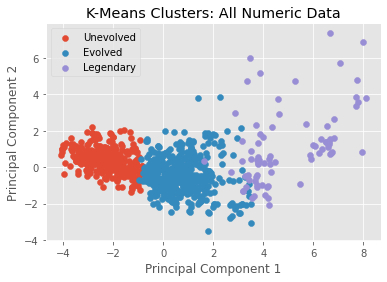

In [39]:
plt.scatter(unevolved.PC1, unevolved.PC2, label='Unevolved')
plt.scatter(evolved.PC1, evolved.PC2, label='Evolved')
plt.scatter(legendary.PC1, legendary.PC2, label='Legendary')
plt.legend(loc='upper left')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters: All Numeric Data")
plt.show()

###Battle Metrics

Moving on to the battle-specific metrics, the elbow method proved more challenging in determining the ideal number of k-means clusters. I see the elbow at two clusters, but a case could be made for four clusters as well.

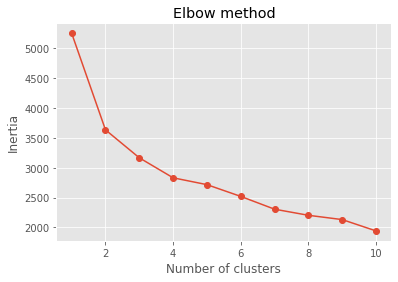

In [40]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=4)
    kmeans.fit(battle_array)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

I fit the battle data to a two cluster model and added the individual Pokemon cluster designations to the battle_pca_df.

In [41]:
kmeans_battle = KMeans(n_clusters=2, n_init='auto', random_state=4)
kmeans_battle.fit(battle_array)

battle_pca_df['cluster_number'] = pd.Series(kmeans_battle.predict(battle_array))
battle_pca_df

,PC1,PC2,name,cluster_number
0,-1.636208,-0.166264,Bulbasaur,0
1,-0.326452,-0.632728,Ivysaur,0
2,1.743582,-0.711562,Venusaur,1
3,-1.817494,-0.473296,Charmander,0
4,-0.346406,-0.913860,Charmeleon,0
...,...,...,...,...
870,1.619308,0.349739,Poipole,1
871,4.040993,0.245792,Naganadel,1
872,6.671013,7.350203,Stakataka,1
873,3.753128,-1.088787,Blacephalon,1


Almost all of the Pokemon in cluster 0 have not completed their evolutionary lineage, thus are smaller and weaker. However, I noticed that there are some fully-evolved Pokemon like Raticate that are still relatively small and weak. Along those lines, I nicknamed this cluster "Weaker".

In [42]:
weaker = battle_pca_df.loc[battle_pca_df.cluster_number == 0].copy()
weaker

,PC1,PC2,name,cluster_number
0,-1.636208,-0.166264,Bulbasaur,0
1,-0.326452,-0.632728,Ivysaur,0
3,-1.817494,-0.473296,Charmander,0
4,-0.346406,-0.913860,Charmeleon,0
6,-1.743792,0.119838,Squirtle,0
...,...,...,...,...
830,-2.951597,-0.107202,Wimpod,0
832,-1.933823,1.188742,Sandygast,0
846,-1.629716,0.413324,Jangmo-o,0
853,-1.311409,1.575577,Cosmog,0


The Pokemon in cluster 1 are stronger and mostly fully-evolved. This group also includes legendary Pokemon. I nicknamed this cluster "Stronger".

In [43]:
stronger = battle_pca_df.loc[battle_pca_df.cluster_number == 1].copy()
stronger

,PC1,PC2,name,cluster_number
2,1.743582,-0.711562,Venusaur,1
5,1.697470,-1.272661,Charizard,1
8,1.657705,-0.581100,Blastoise,1
17,0.805408,-1.061243,Pidgeot,1
21,-0.725057,-0.244115,Alolan Raticate,1
...,...,...,...,...
870,1.619308,0.349739,Poipole,1
871,4.040993,0.245792,Naganadel,1
872,6.671013,7.350203,Stakataka,1
873,3.753128,-1.088787,Blacephalon,1


The k-means clusters plotted out against the principal components illustrate how most of the distinction between clusters occurs along the first principal component. Without the non-battle metrics, k-means clustering cannot distinguish the far right outliers as legendary Pokemon.

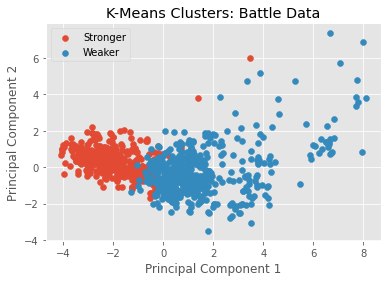

In [44]:
plt.scatter(weaker.PC1, weaker.PC2, label='Stronger')
plt.scatter(stronger.PC1, stronger.PC2, label='Weaker')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters: Battle Data")
plt.legend(loc='upper left')
plt.show()

#Conclusion

The table below summarizes the PCA and K-Means results with all the numeric metrics and the battle-only metrics.

In [45]:
# assign data
mydata = [
    ["All Numeric", "44.5",  "11.7", "3"],
    ["Battle", "43.4", "19.2", "2"]
]
 
# create header
head = ["Metrics", "PC1: % of Variance Explained", "PC2: % of Variance Explained", "# of K-Means Clusters"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+-------------+--------------------------------+--------------------------------+-------------------------+
| Metrics     |   PC1: % of Variance Explained |   PC2: % of Variance Explained |   # of K-Means Clusters |
+=============+================================+================================+=========================+
| All Numeric |                           44.5 |                           11.7 |                       3 |
+-------------+--------------------------------+--------------------------------+-------------------------+
| Battle      |                           43.4 |                           19.2 |                       2 |
+-------------+--------------------------------+--------------------------------+-------------------------+


The principal component analysis results for all the numeric metrics and battle metrics generally mirrored one another. In both cases, the first principal component identified stronger Pokemon. The second principal component identified bulk by correlating negatively with "speed" in both cases. With all the numeric variables, this second component correlated positively with "weight_kg", while with the battle variables, it had a positive correlation with "defense".

For k-means, the extra non-battle metrics provided insight for identifying the third cluster of "legendary" Pokemon species. The model built on battle metrics alone was only able to distinguish two "stronger" and "weaker" clusters. 

When the clusters for both models were plotted against their respective principal components, almost all of the cluster distinctions occurred along the first principal component's axis, meaning Pokemon were clustered by their strength.

Looking specifically at the three clusters built around the numeric data, my hunch is that they are also correlated with Pokemon rarity. The "unevolved" Pokemon can generally be found extensively throughout the games. The "evolved" Pokemon are a little more scarce and can often only be obtained by capturing, training, and evolving the "unevolved" Pokemon. Finally, most of the "legendary" Pokemon can only be obtained once throughout the game in a special encounter. If I could find some kind of rarity index, I would like to follow up this study with an exploration of how rarity correlates with the identified principal components and clusters.